# Estimagic with SciPy's `least_squares`

This is the accompanying documentation to the Pull Request adding the scipy [least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) to [estimagic](https://github.com/OpenSourceEconomics/estimagic).



## Table of Contents:
   1. Project Goals
   2. Modification Process
   3. Underlying Algorithms
   4. Examples
   5. Comparison

## 1. Project Goals
This project adds new internal optimizers to the estimagic library for nonlinear optimization.

### 1.1 Estimagic
[estimagic](https://github.com/OpenSourceEconomics/estimagic) is a Python package that provides tools for nonlinear optimization, numerical differentiation and statistical inference to fit large scale empirical models to data and make inferences about the estimated model parameters. It is well suited to solving difficult constrained optimization problems.

The full documentation can be accessed [here](https://estimagic.readthedocs.io/en/latest/#).

### 1.2 Contribution
estimagic provides a large collection of [internal optimizers](https://estimagic.readthedocs.io/en/latest/explanations/optimization/internal_optimizers.html). 
This project adds two least square algorithms as internal optimizers.
These two new optimizers are based on scipy's least squares implementation, see [scipy.optimize.least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#r20fc1df64af7-stir).

A third possible scipy least squares optimizer, based on the Levenberg-Marquardt algorithm, was not included. It's inabillity to handle bounds or constraints as well as the fact that it requires the number of residuals and number of variables to be equal does not make it a good fit for estimagic's internal optimizer structure.

The added optimizers:
* `scipy_ls_trf`
* `scipy_ls_dogbox`

will be explained and tested within this notebook.

## 2. Modification Process
Almost all modifications where done in the file `estimagic/optimization/scipy_optimizers.py`.
Adding the optimizers was done in the following steps:

1. Add a function `scipy_least_squares`, with the different algorithms (trf and dogbox) as parameters. Later this API was changed (see below).
2. Add the function to the test suite, by marking it as imprecise (i.e. adding it to `IMPRECISE_ALGOS` and `is_least_sqaures` lists).
3. Add relevant parameters to the function and supply them to the underlying `scipy_least_squares` function.
4. Wonder for multiple hours, why `tox` throws errors. Find out that it is because `petsc` Gitlab link was broken.
5. Fix the `petsc` link in the documentation.
6. Change the API to one internal function `_scipy_least_squares` and two front facing functions `scipy_ls_trf` and `scipy_ls_dogbox`. This was done to better fit into the estimagic internal structure.
7. Remove support for the `lm` (Levenberg-Marquardt) method. See section 1.2 for rational.
8. Align tests to points 6. and 7.

## 3. Underlying Algorithms
The `scipy.optimize.least_sqaures` solves a nonlinear least-squares problem with bounds on the variables. 

Internally, it uses three algorithms: 

1. Trust Region Reflective Method (trf)
2. DogBox Method (dogbox)
3. Levenberg-Marquardt Method. 

As Levenberg-Marquardt was not included, the next sections will only introduce the trf and dogbox methods.
This descriptions of the algorithms are heavily based on the [excellent scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#id7).

### 3.1. Trust Region Reflective `scipy_ls_trf`


Method ‘trf’ (Trust Region Reflective) is motivated by the process of solving a system of equations, which constitute the first-order optimality condition for a bound-constrained minimization problem as formulated in [STIR](https://epubs.siam.org/doi/10.1137/S1064827595289108). The algorithm iteratively solves trust-region subproblems augmented by a special diagonal quadratic term and with trust-region shape determined by the distance from the bounds and the direction of the gradient. This enhancements help to avoid making steps directly into bounds and efficiently explore the whole space of variables. To further improve convergence, the algorithm considers search directions reflected from the bounds. With dense Jacobians trust-region subproblems are solved by an exact method. A singular value decomposition of a Jacobian matrix is done once per iteration. For large sparse Jacobians a 2-D subspace approach of solving trust-region subproblems is used [STIR](https://epubs.siam.org/doi/10.1137/S1064827595289108), [Byrd](https://link.springer.com/article/10.1007/BF01580735). The subspace is spanned by a scaled gradient and an approximate Gauss-Newton solution delivered. 
The algorithm works quite robust in unbounded and bounded problems, thus it is chosen as a default algorithm.

### 3.2. DogBox `scipy_ls_dogbox`
Method ‘dogbox’ operates in a trust-region framework, but considers rectangular trust regions as opposed to conventional ellipsoids [Voglis](http://www.cs.uoi.gr/~lagaris/papers/PREPRINTS/dogbox.pdf). The intersection of a current trust region and initial bounds is again rectangular, so on each iteration a quadratic minimization problem subject to bound constraints is solved approximately by Powell’s dogleg method [NumOpt](https://link.springer.com/book/10.1007/978-0-387-40065-5). The required Gauss-Newton step can be computed exactly for dense Jacobians or approximately for large sparse Jacobians. The algorithm is likely to exhibit slow convergence when the rank of Jacobian is less than the number of variables. 

The algorithm often outperforms ‘trf’ in bounded problems with a small number of variables.

### 3.3. Trust Region Methods
Both methods above fall in the category of trust region optimization methods. In general, these algorithms are iterative procedures in which the objective function $f(x)$ is represented by a quadratic model within a trust region. A trust region is a suitable neigborhood of the current itterate, as implied by the Tylor series expansion, such that at its $k^{th}$ itteration, $f(x)$ can be written as:

\begin{align*}
f(x_{k}+s) \approx m_{k}(s) = f(x_{k})+g_{k}^{T}s + \frac{1}{2}s^{T}B_{k}s
\end{align*}

where $g_{k}= \nabla f(x_{k})$ and $B_{k}$ is a symmetric approximation of $\nabla^{2} f(x_{k})$. Then the trust region is defined as:

\begin{align*}
T_{k} = \{x \in \mathfrak{R}^{n}|\, ||x - x_{k}|| \leq \Delta_{k} \}
\end{align*}

Different choices of the norm will lead to different shapes of the trust region. 
Given the model and the trust region, a step $s_{k} \leq \Delta_{k} $ is chosen such that the model is sufficiently reduced in value. Using this step compare the reduction in the model to that in the objective function. If they agree to a certain extend,
the step is accepted and the trust region is either expanded or remains the same. Otherwise the step is rejected and the trust region is contracted.
The very basic trust region algorithm can be seen below:

S0: Set $k=0$ and pick the initial point and and trust region parameter $x_{0}$ and $\Delta_{0}$

S1: Construct a quadratic model: $f(x_{k}+s) \approx m_{k}(s)$

S2: Calculate $s_{k}$ such that $||s_{k}|| \leq \Delta_{k}$ to sufficientl reduce $m_{k}$

S3: Calculate the ratio of actual to expected reduction $r_{k} = \frac{f(x_{k}) - f(x_{k} + s_{k})}{m_{k}(0) - m_{k}(s)}$. Accept the step or not, according to $r_{k}$ and update $\Delta_{k}$.

S4: Increment $k \leftarrow k+1$ and repeat from S1.

The methods above employ this type of algorithm, when solving the optimization problem.

## 4. Examples

### 4.1. Sphere Example
To show that the optimizers work within estimagic, I've included the [Sphere Example](https://estimagic.readthedocs.io/en/latest/getting_started/first_optimization_with_estimagic.html) already used in the documentation. In the current example, the `scipy_ls_trf` optimizer is showcased. In Section 5, a comparison with `scipy_ls_dogbox` and other optimizers from estimagic is presented.


In [1]:
import numpy as np
import pandas as pd
from estimagic import minimize
from estimagic.logging.read_log import read_optimization_iteration

/home/yana/PycharmProjects/estimagic/venv/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### The Sphere Function
The Sphere function takes the form:
\begin{align*}
f(x) = \sum_{i=1}^d {x_{i}^2}
\end{align*}
where $d$ denotes the dimension. It has $d$ local minima except for the global one. It is continuous, convex and unimodal. The unique local and global optimum of this function is at the zero vector.

In [2]:
def sphere(params):
    """Spherical criterion function.

    The unique local and global optimum of this function is at
    the zero vector. It is differentiable, convex and extremely
    well behaved in any possible sense.

    Args:
        params (pandas.DataFrame): DataFrame with the columns
            "value", "lower_bound", "upper_bound" and potentially more.

    Returns:
        dict: A dictionary with the entries "value" and "root_contributions".

    """
    out = {
        "value": (params["value"] ** 2).sum(),
        "root_contributions": params["value"],
    }
    return out


def sphere_gradient(params):
    """Gradient of spherical criterion function"""
    return params["value"] * 2

Setting up start parameters:

In [3]:
start_params = pd.DataFrame(
    data=np.arange(5) + 1,
    columns=["value"],
    index=[f"x_{i}" for i in range(5)],
)

Setting up parameters with bounds:

In [4]:
params_with_bounds = start_params.copy()

params_with_bounds["lower_bound"] = [0, 1, 0, -1, 0]
params_with_bounds["upper_bound"] = [np.inf] * 5

Run an optimization using the algorithm `scipy_ls_trf` and the parameters with bounds:

In [5]:
# With bounds
res = minimize(
    criterion=sphere,
    params=params_with_bounds,
    algorithm="scipy_ls_trf",
    derivative=sphere_gradient
)
res["solution_params"].round(2)

,lower_bound,upper_bound,value
x_0,0.0,inf,0.0
x_1,1.0,inf,1.0
x_2,0.0,inf,0.0
x_3,-1.0,inf,-0.0
x_4,0.0,inf,0.0


Now let's add constraints:

In [6]:
# With bounds and constraints
constraints = [{"loc": ["x_0", "x_3"], "type": "fixed", "value": [1, 4]}]
res = minimize(
    criterion=sphere,
    params=params_with_bounds,
    algorithm="scipy_ls_trf",
    derivative=sphere_gradient,
    constraints=constraints,
)
res["solution_params"].round(2)

,lower_bound,upper_bound,value
x_0,0.0,inf,1.0
x_1,1.0,inf,1.0
x_2,0.0,inf,0.0
x_3,-1.0,inf,4.0
x_4,0.0,inf,0.0


### Supplying Arguments
The included `scipy_ls_trf` optimizer takes arguments (see documentation).
This example sets the method for solving trust-region subproblems `tr_solver` to `exact`. This solver is suitable for not very large problems with dense Jacobian matrices. The computational complexity per iteration is comparable to a singular value composition of the Jacobian matrix.

In [7]:
# Use the exact trust region solver
algo_options = {
    'tr_solver': 'exact'
}

res = minimize(
    criterion=sphere,
    params=start_params,
    algorithm="scipy_ls_trf",
    derivative=sphere_gradient,
    algo_options=algo_options
)
res["solution_params"].round(2)

,lower_bound,upper_bound,value
x_0,-inf,inf,0.0
x_1,-inf,inf,0.0
x_2,-inf,inf,0.0
x_3,-inf,inf,0.0
x_4,-inf,inf,0.0


### 4.2. Rosenbrock Example
To further illustrate the optimizers capabilities, I've also included the Rosenbrock example from the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html). In the current example, the `scipy_ls_trf` optimizer is showcased. In Section 5, a comparison with `scipy_ls_dogbox` and other optimizers from estimagic is presented.

### The Rosenbrock Function
In mathematical optimization, the Rosenbrock function is a non-convex function, introduced by Howard H. Rosenbrock in 1960, which is used as a performance test problem for optimization algorithms. It is also known as Rosenbrock's valley or Rosenbrock's banana function. [[Rosenbrock]](https://academic.oup.com/comjnl/article/3/3/175/345501)
It takes the form of:
\begin{align*}
f(x,y) = (a-x)^2 + b(y-x^2)^2
\end{align*}
The global minimum is inside a long, narrow, parabolic shaped flat valley. To find the valley is trivial. To converge to the global minimum, however, is difficult. It has a global minimum at $(x,y)=(a,a^{2})$, where $f(x,y)=0$. 

In the following example, I am taking $a = 1$ and $b=10$:

In [8]:
def fun_rosenbrock(params):
    x = params["value"]
    res = 10 * (x[1] - x[0]**2)**2 + (1 - x[0])**2
    return {
        "value": res,
        "root_contributions": x
    }


def jac_rosenbrock(params):
    x, y = params["value"]
    return [
        2 * (20 * x**3 - 20 * x * y + x - 1), # diff. by x
        20 * (y - x**2)  # diff. by y
    ]

Setting up start parameters:

In [9]:
x0_rosenbrock = pd.DataFrame(
    data=[2, 2],
    columns=["value"],
    index=[f"x_{i}" for i in range(2)],
)

Optimize without bounds:

In [10]:
# Without bounds
res = minimize(
    criterion=fun_rosenbrock,
    params=x0_rosenbrock,
    algorithm="scipy_ls_trf",
    derivative=jac_rosenbrock,
)
# Function has minima at (1, 1)
res["solution_params"].round(2)

,lower_bound,upper_bound,value
x_0,-inf,inf,1.0
x_1,-inf,inf,1.0


Optimize with bounds:

In [11]:
# With bounds
x0_rosenbrock["lower_bound"] = [-np.inf, 1.5]
x0_rosenbrock["upper_bound"] = [np.inf] * 2
res = minimize(
    criterion=fun_rosenbrock,
    params=x0_rosenbrock,
    algorithm="scipy_ls_dogbox",
    derivative=jac_rosenbrock,
)
# Function has new solution that lies on the bound (1.22, 1.5)
res["solution_params"].round(2)

,lower_bound,upper_bound,value
x_0,-inf,inf,1.22
x_1,1.5,inf,1.50


## 5. Comparison
A quick comparison will show the performance differences of the two new optimizers and other optimizers from estimagic, using the functions presented in Section 4.

In [12]:
from time import time
import seaborn as sns

Set up constraints:

In [13]:
constraints = [{"loc": ["x_0", "x_3"], "type": "fixed", "value": [1, 4]}]

### 5.1. Sphere Function
Pick which optimizers to compare using the sphere function and record their times. In this specific example, since I am using parameters with bounds, I am comparing only optimizers that allow for bounds. Of course, the same exercise can be done without bounds (or constraints).

In [14]:
# All internal optimizers: ["scipy_ls_trf", "scipy_ls_dogbox", "scipy_slsqp", "scipy_lbfgsb", "scipy_neldermead",
# "scipy_powell", "scipy_bfgs", "scipy_conjugate_gradient", "scipy_newton_cg", "scipy_cobyla", "scipy_truncated_newton",
# "scipy_trust_constr"]

# Algorithms that allow for bounds:
ALGORITHMS = ["scipy_ls_trf", "scipy_ls_dogbox", "scipy_slsqp", "scipy_lbfgsb", "scipy_powell",
              "scipy_bfgs", "scipy_truncated_newton", "scipy_trust_constr"]
res = {}
times = {}
for i in ALGORITHMS:
    t0 = time()
    res[i] = minimize(
        criterion=sphere,
        params=params_with_bounds,
        algorithm=i,
        derivative=sphere_gradient,
        constraints=constraints,
    )
    # Record their times
    times[i] = time() - t0

Print the results to see if there is an algorithm that did not manage to find the minima. Note that the entire set of results can be printed. I just chose this particular format, as I used it in the examples in Section 4.

In [15]:
for i in ALGORITHMS:
    print(res[i]["solution_params"].round(2))

     lower_bound  upper_bound  value
x_0          0.0          inf    1.0
x_1          1.0          inf    1.0
x_2          0.0          inf    0.0
x_3         -1.0          inf    4.0
x_4          0.0          inf    0.0
     lower_bound  upper_bound  value
x_0          0.0          inf    1.0
x_1          1.0          inf    1.0
x_2          0.0          inf    0.0
x_3         -1.0          inf    4.0
x_4          0.0          inf    0.0
     lower_bound  upper_bound  value
x_0          0.0          inf    1.0
x_1          1.0          inf    1.0
x_2          0.0          inf    0.0
x_3         -1.0          inf    4.0
x_4          0.0          inf    0.0
     lower_bound  upper_bound  value
x_0          0.0          inf    1.0
x_1          1.0          inf    1.0
x_2          0.0          inf    0.0
x_3         -1.0          inf    4.0
x_4          0.0          inf    0.0
     lower_bound  upper_bound  value
x_0          0.0          inf    1.0
x_1          1.0          inf    1.0
x

Let's see how the different algorithms performed with respect to time:

In [16]:
print(times)

{'scipy_ls_trf': 0.168961763381958, 'scipy_ls_dogbox': 0.0716242790222168, 'scipy_slsqp': 0.06119370460510254, 'scipy_lbfgsb': 0.05652284622192383, 'scipy_powell': 2.1199593544006348, 'scipy_bfgs': 0.09941577911376953, 'scipy_truncated_newton': 0.13450074195861816, 'scipy_trust_constr': 0.27176785469055176}


Plot the results for clarity:

[Text(0, 0, 'scipy_ls_trf'),
 Text(1, 0, 'scipy_ls_dogbox'),
 Text(2, 0, 'scipy_slsqp'),
 Text(3, 0, 'scipy_lbfgsb'),
 Text(4, 0, 'scipy_powell'),
 Text(5, 0, 'scipy_bfgs'),
 Text(6, 0, 'scipy_truncated_newton'),
 Text(7, 0, 'scipy_trust_constr')]

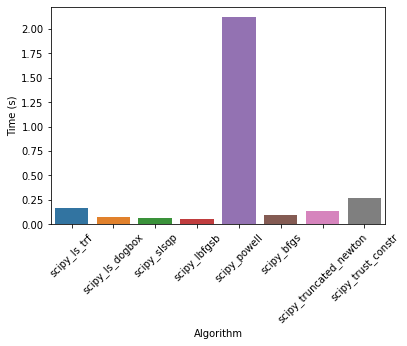

In [17]:
res_data = []
for i in ALGORITHMS:
    res_data.append((i, times[i]))

results = pd.DataFrame(
        data=res_data,
    columns=["Algorithm", "Time (s)"]
)
_ = sns.barplot(x="Algorithm", y="Time (s)", data=results)
_.set_xticklabels(_.get_xticklabels(), rotation=45)

Now let's see how they did with respect to number of evaluations:

[Text(0, 0, 'scipy_ls_trf'),
 Text(1, 0, 'scipy_ls_dogbox'),
 Text(2, 0, 'scipy_slsqp'),
 Text(3, 0, 'scipy_lbfgsb'),
 Text(4, 0, 'scipy_powell'),
 Text(5, 0, 'scipy_bfgs'),
 Text(6, 0, 'scipy_truncated_newton'),
 Text(7, 0, 'scipy_trust_constr')]

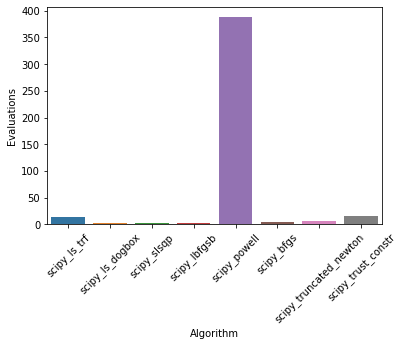

In [18]:
res_data = []
for i in ALGORITHMS:
    res_data.append((i, res[i]['n_criterion_evaluations']))

results = pd.DataFrame(
        data=res_data,
    columns=["Algorithm", "Evaluations"]
)
_ = sns.barplot(x="Algorithm", y="Evaluations", data=results)
_.set_xticklabels(_.get_xticklabels(), rotation=45)

Given a simple example function - like the sphere function - the new optimizers perform as well as or better than the existing optimizers in estimagic. 

The plots show that for a bounded problem with few variables, the `scipy_ls_dogbox` outperforms `scipy_ls_trf` both in terms of evalutaions and runtime. 

### 5.2. Rosenbrock Function
I would like to compare the performance of the above algorithms using another function. Notice how easy it is to change the function, parameters and its derivative. The code allows for perspecitve users to pick the best optimizers for their needs by supplying the necessary arguments and selecting which algorithms to be compared.

In [19]:
ALGORITHMS = ["scipy_ls_trf", "scipy_ls_dogbox", "scipy_slsqp", "scipy_lbfgsb", "scipy_powell",
              "scipy_bfgs", "scipy_truncated_newton", "scipy_trust_constr"]
res = {}
times = {}
for i in ALGORITHMS:
    t0 = time()
    res[i] = minimize(
        criterion=fun_rosenbrock,
        params=x0_rosenbrock,
        algorithm=i,
        derivative=jac_rosenbrock,
    )
    # Record their times
    times[i] = time() - t0

Print the results to see if there is an algorithm that did not manage to find the minima. Note that the entire set of results can be printed. I just chose this particular format, as I used it in the examples in Section 4. The BFGE `scipy_bfgs` algorithm did not manage to find the minima.

In [20]:
for i in ALGORITHMS:
    print(res[i]["solution_params"].round(2))

     lower_bound  upper_bound  value
x_0         -inf          inf   1.22
x_1          1.5          inf   1.50
     lower_bound  upper_bound  value
x_0         -inf          inf   1.22
x_1          1.5          inf   1.50
     lower_bound  upper_bound  value
x_0         -inf          inf   1.22
x_1          1.5          inf   1.50
     lower_bound  upper_bound  value
x_0         -inf          inf   1.22
x_1          1.5          inf   1.50
     lower_bound  upper_bound  value
x_0         -inf          inf   1.22
x_1          1.5          inf   1.50
     lower_bound  upper_bound  value
x_0         -inf          inf    1.0
x_1          1.5          inf    1.0
     lower_bound  upper_bound  value
x_0         -inf          inf   1.22
x_1          1.5          inf   1.50
     lower_bound  upper_bound  value
x_0         -inf          inf   1.22
x_1          1.5          inf   1.50


Let's see how the different algorithms performed with respect to time:

In [21]:
print(times)

{'scipy_ls_trf': 78.39277768135071, 'scipy_ls_dogbox': 14.29269528388977, 'scipy_slsqp': 0.16037869453430176, 'scipy_lbfgsb': 0.1931929588317871, 'scipy_powell': 3.6261954307556152, 'scipy_bfgs': 0.26512646675109863, 'scipy_truncated_newton': 0.1861710548400879, 'scipy_trust_constr': 0.48113441467285156}


Plot the results for clarity:

[Text(0, 0, 'scipy_ls_trf'),
 Text(1, 0, 'scipy_ls_dogbox'),
 Text(2, 0, 'scipy_slsqp'),
 Text(3, 0, 'scipy_lbfgsb'),
 Text(4, 0, 'scipy_powell'),
 Text(5, 0, 'scipy_bfgs'),
 Text(6, 0, 'scipy_truncated_newton'),
 Text(7, 0, 'scipy_trust_constr')]

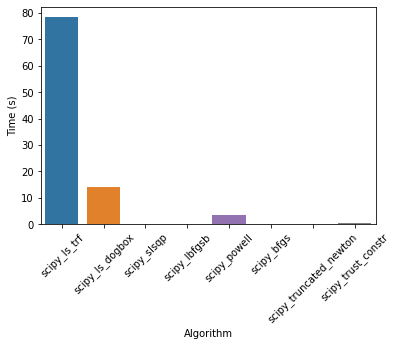

In [22]:
res_data = []
for i in ALGORITHMS:
    res_data.append((i, times[i]))

results = pd.DataFrame(
        data=res_data,
    columns=["Algorithm", "Time (s)"]
)
_ = sns.barplot(x="Algorithm", y="Time (s)", data=results)
_.set_xticklabels(_.get_xticklabels(), rotation=45)

Now let's see how they did with respect to number of evaluations:

[Text(0, 0, 'scipy_ls_trf'),
 Text(1, 0, 'scipy_ls_dogbox'),
 Text(2, 0, 'scipy_slsqp'),
 Text(3, 0, 'scipy_lbfgsb'),
 Text(4, 0, 'scipy_powell'),
 Text(5, 0, 'scipy_bfgs'),
 Text(6, 0, 'scipy_truncated_newton'),
 Text(7, 0, 'scipy_trust_constr')]

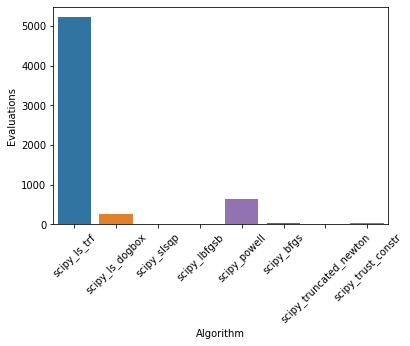

In [23]:
res_data = []
for i in ALGORITHMS:
    res_data.append((i, res[i]['n_criterion_evaluations']))

results = pd.DataFrame(
        data=res_data,
    columns=["Algorithm", "Evaluations"]
)
_ = sns.barplot(x="Algorithm", y="Evaluations", data=results)
_.set_xticklabels(_.get_xticklabels(), rotation=45)

The plots show that for a bounded problem with few variables, the `scipy_ls_dogbox` outperforms `scipy_ls_trf` both in terms of evalutaions and runtime. However, both of them perform poorly relative to the other internal optimizers that were used in the comparison.